# B-Splines Datenfit

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from numpy.random import normal
from scipy.linalg import solve_triangular

## Datenset

Zu Testzwecke generieren wir ein Datenset basierend auf einer Funktion, welche wir mit einem normal verteilten Rauschen überlagern. Grundsätzlich betrachten wir hier den Datenfit aus der Perspektive, dass kein Wissen bezüglich Modellfunktion vorhanden ist und benutzen daher B-Splines als Basisfunktionen für die lineare Ausgleichsrechnung.

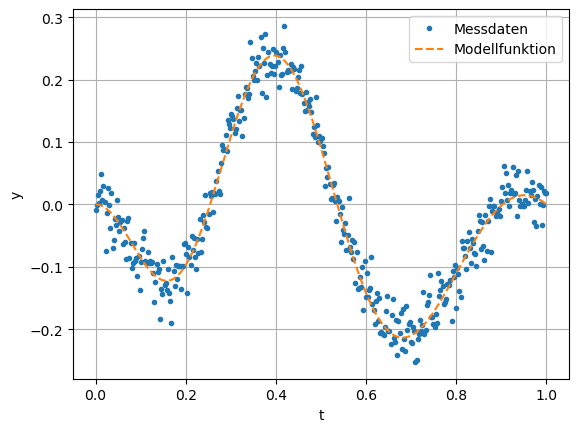

In [2]:
ti = np.linspace(0,1,400)
fi = np.sin((4*np.pi)/(1+1/4*ti**2)*ti)*(ti*(ti-1))
noise = normal(scale=0.025,size=fi.shape)
yi = fi+noise

plt.plot(ti,yi,'.', label='Messdaten')
plt.plot(ti,fi,'--', label='Modellfunktion')
plt.legend()
plt.xlabel('t')
plt.ylabel('y')
plt.grid()
plt.show()

## Datenfit

Wir erweitern die BSplines Klasse aus der B-Splines Einführung mit der Funktionalität die Systemmatrix

\begin{split}
A_T & = (N_{j,k}(x_i))_{i=1,j=1}^{m,k+\ell}\in\mathbb{R}^{m\times (k+\ell)}\\
f & = (f_1, \ldots, f_m)^T\in\mathbb{R}^m. 
\end{split}

für die lineare Ausgleichsrechnung berechnen zu können.




In [3]:
class BSplines:
    def __init__(self,tau, k):
        self.k = k
        self.tau = tau
        self.t = np.array([tau[0]]*(k-1) + tau.tolist()+ [tau[-1]]*(k-1))

    def N(self,x,j,k=None):
        '''BSpline Basis Funktion'''
        if k == None:
            k = self.k
        if k == 1:
            ind = (self.t[j] <= x)*(x < self.t[j+1])
            return np.array(ind, dtype=float)
        else:
            if type(x) == np.ndarray:
                y = np.zeros_like(x)
            else:
                y = 0
            if self.t[j] < self.t[j+k-1]:
                y += (x-self.t[j])/(self.t[j+k-1]-self.t[j])*self.N(x, j, k-1)
            if self.t[j+1] < self.t[j+k]:
                y += (self.t[j+k]-x)/(self.t[j+k]-self.t[j+1])*self.N(x, j+1, k-1)
            return y
    
    def S(self,x,c):
        assert (len(c) <= len(self.t)-self.k)
        return sum(c[j] * self.N(x, j) for j in range(len(c)))
    
    def getSystem(self,x,k=None):
        if k == None:
            k = self.k
        sys = []
        for j in range(len(self.t)-self.k):
            sys.append(self.N(x,j,k))
        sys = np.array(sys).T
        return sys

Im Beispiel Zerlegen wir den Parameter $t\in [0,1]$ für den Datenfit in 10 Intervalle. Dabei wählen wir den Parameter bereich leicht grösser, um Randeffekte für $t=0$ bzw. $t=1$ zu vermeiden.

In [4]:
N = 10
tau = np.linspace(-1e-5,1+1e-5,N+1)

Für das Beispiel benutzen wir Polynome 3. Grades, was der B-Spline Ordnung 4 entspricht.

In [5]:
bspline = BSplines(tau,4)

Mit Hilfe der QR-Zerlegung berechnen wir die B-Splines Koeffizienten:

In [6]:
A = bspline.getSystem(ti)
q,r = np.linalg.qr(A)
c = solve_triangular(r,q.T@yi)

und erhalten ein qualitativ sehr gutes Modell für das gegebene Datenset

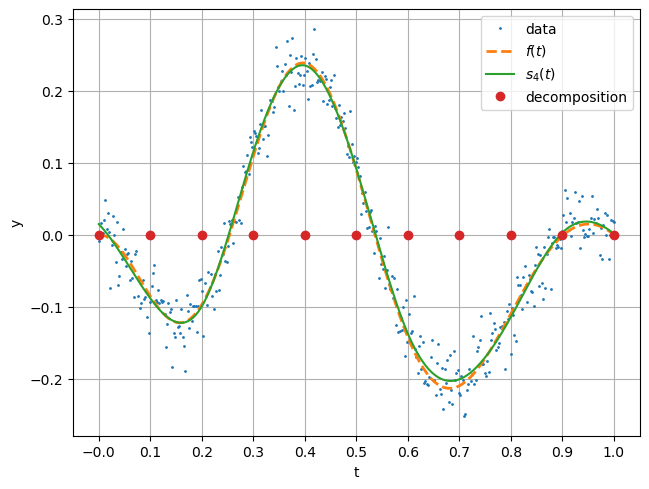

In [7]:
plt.plot(ti,yi,'.',ms=2,label='data')
plt.plot(ti,fi,'--',lw=2,label=r'$f(t)$')
plt.plot(ti,bspline.S(ti,c),label=r'$s_'+str(bspline.k)+'(t)$')
plt.plot(tau,np.zeros_like(tau),'o',label='decomposition')
plt.xticks(tau)
plt.legend()
plt.grid()
plt.tight_layout()
plt.xlabel('t')
plt.ylabel('y')
plt.savefig('BSplineDataFit.pdf')
plt.show()

**Aufgabe:** Studieren Sie den Einfluss des B-Splines Grades und der Zerlegung, in dem Sie die Parameter modifizieren.

## Datenfit - Smoothing Splines

Wählt man eine immer feinere Zerlegung, wird der Datenfit nicht zwingend besser. Im Gegenteil es besteht die Gefahr, dass die Splines dem Rauschen zu folgen beginnt, wie im folgenden Beispiel zu beobachten ist. Zur Illustration benutzen wir nun 100 Intervalle.

In [8]:
N = 100
tau = np.linspace(-1e-5,1+1e-5,N+1)
bspline = BSplines(tau,4)
A = bspline.getSystem(ti)
q,r = np.linalg.qr(A)
c = solve_triangular(r,q.T@yi)

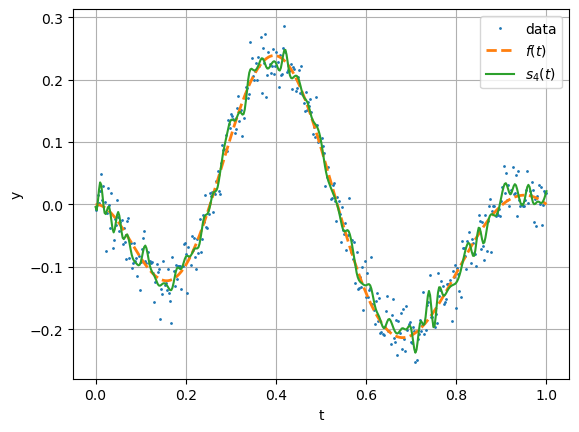

In [9]:
plt.plot(ti,yi,'.',ms=2,label='data')
plt.plot(ti,fi,'--',lw=2,label=r'$f(t)$')
plt.plot(ti,bspline.S(ti,c),label=r'$s_'+str(bspline.k)+'(t)$')
plt.legend()
plt.grid()
plt.xlabel('t')
plt.ylabel('y')
plt.show()

Dies kann mit einem geglätteten Datenfit unterdrückt werden (smoothing splines). Als zusätzlichen Summand im Funktional wird die approximative Krümmung, gegeben durch die zweite Ableitung, berücksichtigt.

$$\sum_{j=1}^m (S(x_j) -f_j)^2 + \theta \|S''\|_2^2 = \sum_{j=1}^m (S(x_j) -f_j)^2 + \theta \int_a^b |S''(x)|^2 dx \to \min$$

Wir erweitern die Klasse mit der Funktionalität einen geglätteten Datenfit berechnen zu können. Für Details zur Implementierung sei auf die Skript Referenz [1], Kap. 9.3 Datenfit–Smoothing Splines verwiesen.

In [10]:
# Wir leiten die erweiterte Klasse von der obigen ab und erweitern sie:
class BSplinesExt(BSplines):
    def L2N(self, j, k=None, Nint=20):
        # numerische Integration der L2-Norm
        if k == None:
            k = self.k
        from scipy.integrate import fixed_quad
        ti = np.linspace(self.t[j], self.t[j+k],Nint+1)
        return np.sum([fixed_quad(lambda t: self.N(t,j,k)**2, ti[i], ti[i+1], n=2*self.k)[0] for i in range(Nint)])
        
    def _getRegMatrix(self, k=None):
        # Berechnung der zusätzlichen Regularisierungs Systemmatrix
        if k == None:
            k = self.k
        assert k > 2
        # Implementierung Skript Referenz [1] Kap. 9.3 Datenfit–Smoothing Splines
        BT = np.zeros((len(self.t)-self.k-2,len(self.t)-self.k))
        for j in range(2,len(self.t)-self.k):
            dj = (k-1)*(k-2)/(self.t[j+k-2]-self.t[j])*self.L2N(j,k-2)
            BT[j-2,j-2] = dj/(self.t[j+k-2]-self.t[j-1])
            BT[j-2,j] = dj/(self.t[j+k-1]-self.t[j])
            BT[j-2,j-1] = - (BT[j-2,j-2]+BT[j-2,j])
        return BT
    
    def getRegSystem(self, x, y, theta, k=None):
        # Komposition der beiden Systemmatrizen
        if k == None:
            k = self.k
        assert k > 2
        
        AT = self.getSystem(x,k=k)
        BT = self._getRegMatrix(k = k)
        
        return np.concatenate((AT, theta*BT), axis=0), np.concatenate((y, np.zeros(len(self.t)-self.k-2)), axis=0)

Wir benutzen die feine Zerlegung von oben, wiederum für B-Splines der Ordnung 4 bzw. Polynome 3. Grades:

In [11]:
bsplineExt = BSplinesExt(tau,4)

und berechnen den regularisierten Datenfit mit unterschiedlichen Gewichte $\theta$

In [12]:
# theta = 0
# daher ohne Regularisierung
A, yiExt = bsplineExt.getRegSystem(ti, yi, 0)
q,r = np.linalg.qr(A)
c = solve_triangular(r,q.T@yiExt)

In [13]:
# theta = 0.2
A, yiExt = bsplineExt.getRegSystem(ti, yi, 0.2)
q,r = np.linalg.qr(A)
c1 = solve_triangular(r,q.T@yiExt)

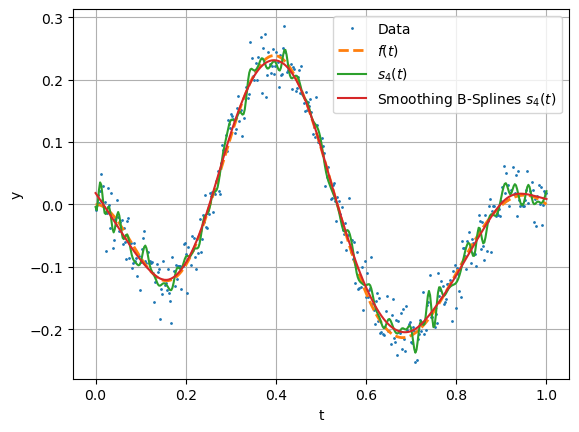

In [14]:
plt.plot(ti,yi,'.',ms=2,label='Data')
plt.plot(ti,fi,'--',lw=2,label=r'$f(t)$')
plt.plot(ti,bsplineExt.S(ti,c),label=r'$s_'+str(bspline.k)+'(t)$')
plt.plot(ti,bsplineExt.S(ti,c1),label=r'Smoothing B-Splines $s_'+str(bspline.k)+'(t)$')
plt.legend()
plt.grid()
plt.xlabel('t')
plt.ylabel('y')
plt.savefig('BSplineSmoothingDataFit.pdf')
plt.show()